<a href="https://colab.research.google.com/github/shreyjain26/Sentiment_Analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re

from collections import Counter
from sklearn.model_selection import KFold

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.lancaster import LancasterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data = pd.read_csv('text_emotion.csv')
data

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...
...,...,...,...,...
39995,1753918954,neutral,showMe_Heaven,@JohnLloydTaylor
39996,1753919001,love,drapeaux,Happy Mothers Day All my love
39997,1753919005,love,JenniRox,Happy Mother's Day to all the mommies out ther...
39998,1753919043,happiness,ipdaman1,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...


In [ ]:
print(data.info(), data.columns)
data.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   author     40000 non-null  object
 3   content    40000 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB
None Index(['tweet_id', 'sentiment', 'author', 'content'], dtype='object')


,tweet_id,sentiment,author,content
count,4.000000e+04,40000,40000,40000
unique,NaN,13,33871,39827
top,NaN,neutral,MissxMarisa,I just received a mothers day card from my lov...
freq,NaN,8638,23,14
mean,1.845184e+09,NaN,NaN,NaN
std,1.188579e+08,NaN,NaN,NaN
min,1.693956e+09,NaN,NaN,NaN
25%,1.751431e+09,NaN,NaN,NaN
50%,1.855443e+09,NaN,NaN,NaN
75%,1.962781e+09,NaN,NaN,NaN


In [ ]:
data['sentiment'].value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

In [ ]:
data.isnull().sum()

tweet_id     0
sentiment    0
author       0
content      0
dtype: int64

<Axes: >

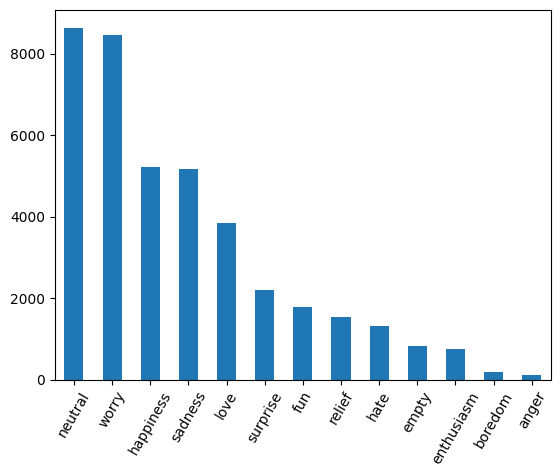

In [ ]:
data['sentiment'].value_counts().plot(kind='bar', rot=60)

There is an imbalance in the data so the results might me skewed towards the classes with higher frequency.

There are 13 different sentiments in this dataset. Let's take a look at a few sentences corresponding to each sentiment.

In [ ]:
data[data['sentiment'] == 'neutral']

,tweet_id,sentiment,author,content
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...
10,1956969456,neutral,feinyheiny,cant fall asleep
22,1956972116,neutral,jansc,No Topic Maps talks at the Balisage Markup Con...
31,1956975441,neutral,LovableKeKe,@cynthia_123 i cant sleep
32,1956975860,neutral,analalalah,I missed the bl***y bus!!!!!!!!
...,...,...,...,...
39990,1753918829,neutral,kdpaine,@shonali I think the lesson of the day is not ...
39991,1753918846,neutral,x0159432,@lovelylisaj can you give me the link for the ...
39992,1753918881,neutral,_Alectrona_,@jasimmo Ooo showing of your French skills!! l...
39993,1753918892,neutral,bushidosan,"@sendsome2me haha, yeah. Twitter has many uses..."


In [ ]:
data[data['sentiment']=='worry']

,tweet_id,sentiment,author,content
5,1956968477,worry,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to...
7,1956968636,worry,mcsleazy,Hmmm. http://www.djhero.com/ is down
11,1956969531,worry,dudeitsmanda,Choked on her retainers
18,1956971473,worry,LCJ82,@PerezHilton lady gaga tweeted about not being...
20,1956971981,worry,andreagauster,@raaaaaaek oh too bad! I hope it gets better. ...
...,...,...,...,...
39936,1753903426,worry,carastjohn,tomorrow is going to be sooo awkward &amp; emb...
39938,1753903505,worry,primatage,"@icebergstorm hey! negative on the primatech, ..."
39941,1753903578,worry,somemandy,@PH7S sure. But be careful also of making stat...
39956,1753903987,worry,nadszy,How Do You Sleep - Jesse McCartney


In [ ]:
data[data['sentiment']=='boredom']

,tweet_id,sentiment,author,content
112,1956993007,boredom,villa_ld,i'm so tired
316,1957038475,boredom,kameezy,Waiting in line @ tryst
345,1957044366,boredom,snoopync18,why did i agree to work a double shift
495,1957083786,boredom,munkeysmomma,"is really, really bored... I guess I will go t..."
583,1957102562,boredom,Quastbabynumbr5,So deep its priecing my soul
...,...,...,...,...
38952,1753743277,boredom,wyndwitch,@carlysmum lol takes some getting use to Just...
38961,1753743548,boredom,Misses_Gola,@lovely_sara I'm sitting in the bus to dublin ...
39105,1753760150,boredom,jarrelt,@astrylnaut yeah talking to you was too boring
39604,1753851840,boredom,chickenpantz,"just finished some Sunday cleaning, waiting to..."


looking at the above details, we can see that there are a lot of account/ profile tags in the sentences. These tags do not contribute to the sentiment of the text, so we will get rid of that.

There are also a lot of shortcut texts such as listenin, waitin, &am, some undefined words that express emotions such as oo, hmm, lol, ughh etc. We need these in the dataset.

There are some words which have been misspelled but are relevant words, so will have to keep them.

We cannot use lemmetization because shortcut texts like listenin, waitin may get appropriated and this may cause loss of context in the sentences for the model and may reduce the accuracy.

In [ ]:
df = pd.DataFrame()
df['sentiment']=data['sentiment'].astype('category').cat.codes
df['author']=data['author'].astype('category').cat.codes
df['content']=data['content'].astype('category').cat.codes
df['tweet-id'] = data['tweet_id'].astype('category').cat.codes
df.corr()

,sentiment,author,content,tweet-id
sentiment,1.000000,0.004010,0.031146,0.265481
author,0.004010,1.000000,0.040418,-0.017607
content,0.031146,0.040418,1.000000,0.074114
tweet-id,0.265481,-0.017607,0.074114,1.000000


We can see that the correlation between sentiment and author is 0.004 and the correlation between author and content is 0.04 while the correlation between content and semtiment is 0.03. The reason why correlation between author-content is greater than content-sentiment is that the authors are unique whiile the words in the sentence may individually represent different sentiments or more than one sentiment. However, since author data does not affect the sentiment, we will drop it from our dataset.

The same is the case with tweet-id, it has high correlation but little relevant data. The high correlation is because of the unique id.

In [ ]:
data = data.drop(columns=['tweet_id', 'author'])
data.head()

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...


Now let's get rid of the tags.

In [ ]:
tokenizer = TweetTokenizer()
stemmer = LancasterStemmer()
stop_words = set(stopwords.words('english'))
print(stop_words)

{"don't", 'until', 'be', 'at', 'yourselves', 'herself', 'it', 'during', 'on', 'were', 's', 'isn', 'off', 'few', 'just', "isn't", 'but', 'some', 'them', 'why', 'has', 'been', 'all', "didn't", 'there', 'you', 'than', 'doing', 'the', "shouldn't", 'against', 'is', 'between', 'needn', "aren't", 'down', 'not', 'y', 'own', 'wasn', 'wouldn', 'a', 'nor', 'as', 'once', "needn't", 'me', 'in', 'i', 'whom', 'shouldn', 'weren', 'her', 'only', 'that', 'most', 'such', 'yours', 'should', "she's", 'then', 'no', 'o', 'below', 'couldn', 'aren', 'while', 'each', 'after', 'm', 're', 'having', 'same', 'about', 'can', "mustn't", 'hasn', 'further', 'did', 'itself', 'does', 'ours', 'up', 'its', 'am', 'into', 'd', 'theirs', 'to', 'will', 'was', 'an', 'by', "you'd", 'or', 'from', "mightn't", "that'll", 'we', 'll', 'out', 'his', "weren't", 'myself', 'yourself', "wasn't", 'where', 'mustn', 'they', 'now', 'haven', 'this', "couldn't", "hadn't", "shan't", 'himself', 'which', 't', "haven't", 'other', 'didn', 'hadn', 'i

In [ ]:
def preprocess_text(text):
  text = re.sub(r'@\w+', '', text)
  text = re.sub(r'\$\w+', '', text)
  text = re.sub(r'http\S+', '', text)
  text = re.sub(r'[^\w\s]', '', text)

  words = tokenizer.tokenize(text)
  words = [word.lower() for word in words if word.lower() not in stop_words]
  stemmed_words = [stemmer.stem(word) for word in words]
  text = ' '.join(stemmed_words)
  return text

In [ ]:
data['clean_content'] = data['content'].apply(preprocess_text)
data.head(10)

,sentiment,content,clean_content
0,empty,@tiffanylue i know i was listenin to bad habi...,know listenin bad habit ear start freakin part
1,sadness,Layin n bed with a headache ughhhh...waitin o...,layin n bed headach ughhhhwaitin cal
2,sadness,Funeral ceremony...gloomy friday...,fun ceremonygloom friday
3,enthusiasm,wants to hang out with friends SOON!,want hang friend soon
4,neutral,@dannycastillo We want to trade with someone w...,want trad someon houston ticket on
5,worry,Re-pinging @ghostridah14: why didn't you go to...,rep didnt go prom bc bf didnt lik friend
6,sadness,"I should be sleep, but im not! thinking about ...",sleep im think old friend want hes marry damn ...
7,worry,Hmmm. http://www.djhero.com/ is down,hmmm
8,sadness,@charviray Charlene my love. I miss you,charl lov miss
9,sadness,@kelcouch I'm sorry at least it's Friday?,im sorry least friday


In [ ]:
counter = Counter()
for _, row in data.iterrows():
    counter.update(row['clean_content'].split())
counts = pd.DataFrame(counter.most_common(), columns=['word', 'count'])
counts['cumulative'] = counts['count'].cumsum() / counts['count'].sum()

In [ ]:
# making a vocabulary lookup from top 95% of most common words
cutoff = .95
vocab = dict()
for idx, row in counts.iterrows():
    if row['cumulative'] > cutoff:
        break
    vocab[row['word']] = idx

len(vocab)

11574

In [ ]:
word_to_index = {word: index for index, word in enumerate(sorted(vocab))}
print(word_to_index)

In [ ]:
def encode_sentence(sentence, vocab):
    return [vocab[word] for word in sentence.split() if word in vocab]

In [ ]:
data['encoded_content'] = data['clean_content'].apply(encode_sentence, args=(vocab,))
data.head()

,sentiment,content,clean_content,encoded_content
0,empty,@tiffanylue i know i was listenin to bad habi...,know listenin bad habit ear start freakin part,"[19, 2578, 64, 2984, 116, 89, 1008, 382]"
1,sadness,Layin n bed with a headache ughhhh...waitin o...,layin n bed headach ughhhhwaitin cal,"[6540, 223, 91, 318, 9348, 96]"
2,sadness,Funeral ceremony...gloomy friday...,fun ceremonygloom friday,"[55, 9349, 157]"
3,enthusiasm,wants to hang out with friends SOON!,want hang friend soon,"[20, 371, 70, 107]"
4,neutral,@dannycastillo We want to trade with someone w...,want trad someon houston ticket on,"[20, 1522, 179, 2033, 398, 16]"


In [ ]:
# find max sequence length
max_sequence_length = max(data['encoded_content'].apply(len))
max_sequence_length

31

In [ ]:
labels = {value: idx for idx, value in enumerate(data['sentiment'].unique())}
labels

{'empty': 0,
 'sadness': 1,
 'enthusiasm': 2,
 'neutral': 3,
 'worry': 4,
 'surprise': 5,
 'love': 6,
 'fun': 7,
 'hate': 8,
 'happiness': 9,
 'boredom': 10,
 'relief': 11,
 'anger': 12}

In [ ]:
data['label'] = data['sentiment'].apply(lambda x: labels[x])
data.head(10)

,sentiment,content,clean_content,encoded_content,label
0,empty,@tiffanylue i know i was listenin to bad habi...,know listenin bad habit ear start freakin part,"[19, 2578, 64, 2984, 116, 89, 1008, 382]",0
1,sadness,Layin n bed with a headache ughhhh...waitin o...,layin n bed headach ughhhhwaitin cal,"[6540, 223, 91, 318, 9348, 96]",1
2,sadness,Funeral ceremony...gloomy friday...,fun ceremonygloom friday,"[55, 9349, 157]",1
3,enthusiasm,wants to hang out with friends SOON!,want hang friend soon,"[20, 371, 70, 107]",2
4,neutral,@dannycastillo We want to trade with someone w...,want trad someon houston ticket on,"[20, 1522, 179, 2033, 398, 16]",3
5,worry,Re-pinging @ghostridah14: why didn't you go to...,rep didnt go prom bc bf didnt lik friend,"[1484, 68, 7, 457, 729, 1302, 68, 6, 70]",4
6,sadness,"I should be sleep, but im not! thinking about ...",sleep im think old friend want hes marry damn ...,"[67, 0, 25, 152, 70, 20, 231, 837, 176, 37, 20...",1
7,worry,Hmmm. http://www.djhero.com/ is down,hmmm,[885],4
8,sadness,@charviray Charlene my love. I miss you,charl lov miss,"[2759, 5, 18]",1
9,sadness,@kelcouch I'm sorry at least it's Friday?,im sorry least friday,"[0, 66, 263, 157]",1


Now let's create another DataFrame containing only the encoded clean content and labels

In [ ]:
working_data = data[['encoded_content','label']]
working_data.head(10)

,encoded_content,label
0,"[19, 2578, 64, 2984, 116, 89, 1008, 382]",0
1,"[6540, 223, 91, 318, 9348, 96]",1
2,"[55, 9349, 157]",1
3,"[20, 371, 70, 107]",2
4,"[20, 1522, 179, 2033, 398, 16]",3
5,"[1484, 68, 7, 457, 729, 1302, 68, 6, 70]",4
6,"[67, 0, 25, 152, 70, 20, 231, 837, 176, 37, 20...",1
7,[885],4
8,"[2759, 5, 18]",1
9,"[0, 66, 263, 157]",1


In [ ]:
data_Y = data['label'].values
data_X = data['encoded_content'].values

In [ ]:
data_Y.shape, data_X.shape

((40000,), (40000,))

In [ ]:
padded_data_X = np.array([[0] * (max_sequence_length - len(lst)) + lst for lst in data_X])

In [ ]:
padded_data_X.shape, padded_data_X[:10]

((40000, 31),
 array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,   19, 2578,   64, 2984,  116,   89, 1008,  382],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0, 6540,  223,   91,  318, 9348,   96],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,   55, 9349,  157],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,   20,  371,   70,  107],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0

In [ ]:
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(padded_data_X):
    X_train, X_test = padded_data_X[train_index], padded_data_X[test_index]
    y_train, y_test = data_Y[train_index], data_Y[test_index]

    train_index, val_index = next(kf.split(X_train))
    X_train, X_val = X_train[train_index], X_train[val_index]
    y_train, y_val = y_train[train_index], y_train[val_index]

In [ ]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((32400, 31), (3600, 31), (4000, 31), (32400,), (3600,), (4000,))

In [ ]:
class Sentiment_model:
  def __init__(self, vocab_size, embedding_dim):
    self.model = tf.keras.Sequential([
        tf.keras.layers.Input(vocab_size),
        tf.keras.layers.Embedding(input_dim=embedding_dim, output_dim=128),
        tf.keras.layers.LSTM(128, dropout=0.5),
        tf.keras.layers.Dense(13, activation='softmax'),
    ])

    self.model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'mae'])

  def train(self, x_train, y_train, batch_size=32, epochs=10, validation_data=None):
    history = self.model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=validation_data)
    return history

  def evaluate(self, x_test, y_test):
    evaluation = self.model.evaluate(x_test, y_test)
    return evaluation

  def predict(self, x):
    predictions = self.model.predict(x)
    return predictions

In [ ]:
model = Sentiment_model(vocab_size=max_sequence_length, embedding_dim=11574)

In [ ]:
model_history = model.train(X_train, y_train, validation_data=(X_val, y_val))

Epoch 1/10
1013/1013 [==============================] - 23s 21ms/step - loss: 2.0052 - accuracy: 0.3089 - mae: 4.6729 - val_loss: 1.8728 - val_accuracy: 0.3319 - val_mae: 3.7285
Epoch 2/10
1013/1013 [==============================] - 7s 7ms/step - loss: 1.8307 - accuracy: 0.3789 - mae: 4.6729 - val_loss: 1.8361 - val_accuracy: 0.3556 - val_mae: 3.7285
Epoch 3/10
1013/1013 [==============================] - 8s 8ms/step - loss: 1.7131 - accuracy: 0.4241 - mae: 4.6729 - val_loss: 1.8848 - val_accuracy: 0.3428 - val_mae: 3.7285
Epoch 4/10
1013/1013 [==============================] - 6s 6ms/step - loss: 1.5978 - accuracy: 0.4646 - mae: 4.6729 - val_loss: 1.9250 - val_accuracy: 0.3222 - val_mae: 3.7285
Epoch 5/10
1013/1013 [==============================] - 7s 7ms/step - loss: 1.4946 - accuracy: 0.5001 - mae: 4.6729 - val_loss: 1.9781 - val_accuracy: 0.3258 - val_mae: 3.7285
Epoch 6/10
1013/1013 [==============================] - 9s 9ms/step - loss: 1.3971 - accuracy: 0.5331 - mae: 4.6729 - 

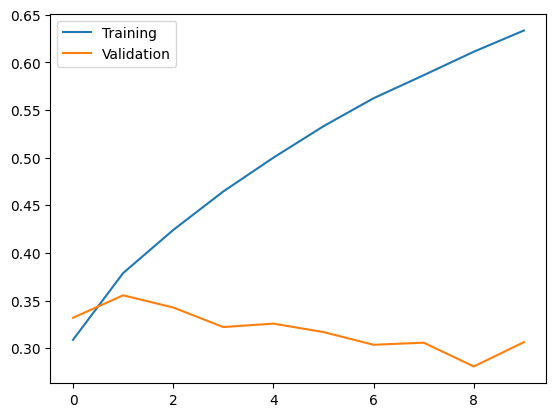

In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.show()

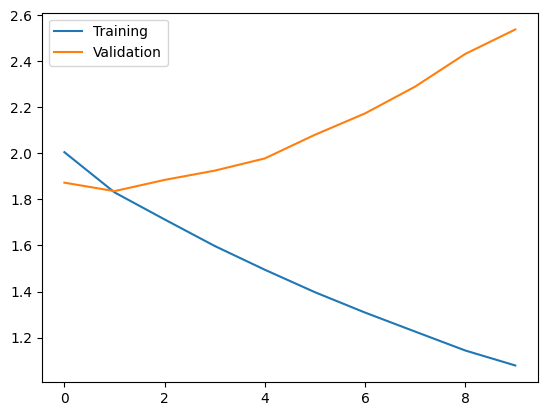

In [ ]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.show()

In [ ]:
del model_history

The model has performed badly specially on the validation set. Let us take a look the evaluations.

In [ ]:
evaluation_history = model.evaluate(X_test, y_test)

125/125 [==============================] - 0s 4ms/step - loss: 2.6378 - accuracy: 0.3000 - mae: 5.6093


In [ ]:
evaluation_history

[2.6378378868103027, 0.30000001192092896, 5.609326362609863]

Let's create a new model and train on more epochs, we may be able to improve it.

In [ ]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(schedule=scheduler)

In [ ]:
from keras.optimizers.optimizer import learning_rate_schedule
class Sentiment_model2:
  def __init__(self, vocab_size, embedding_dim):
    self.model = tf.keras.Sequential([
        tf.keras.layers.Input(vocab_size),
        tf.keras.layers.Embedding(input_dim=embedding_dim, output_dim=256),
        tf.keras.layers.LSTM(256, dropout=0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(13, activation='softmax'),
    ])

    self.model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  def train(self, x_train, y_train, batch_size=32, epochs=10, validation_data=None):
    history = self.model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=validation_data, callbacks=[lr_scheduler])
    return history

  def evaluate(self, x_test, y_test):
    evaluation = self.model.evaluate(x_test, y_test)
    return evaluation

  def predict(self, x):
    predictions = self.model.predict(x)
    return predictions

In [ ]:
model_2 = Sentiment_model2(vocab_size=max_sequence_length, embedding_dim=11574)
model_history_2 = model_2.train(X_train, y_train, batch_size=64, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
507/507 [==============================] - 29s 51ms/step - loss: 2.1145 - accuracy: 0.2875 - val_loss: 2.2391 - val_accuracy: 0.1222 - lr: 0.0010
Epoch 2/20
507/507 [==============================] - 7s 13ms/step - loss: 1.8449 - accuracy: 0.3730 - val_loss: 2.0038 - val_accuracy: 0.3508 - lr: 0.0010
Epoch 3/20
507/507 [==============================] - 6s 12ms/step - loss: 1.6979 - accuracy: 0.4211 - val_loss: 3.0090 - val_accuracy: 0.0739 - lr: 0.0010
Epoch 4/20
507/507 [==============================] - 4s 8ms/step - loss: 1.5591 - accuracy: 0.4687 - val_loss: 2.7274 - val_accuracy: 0.1978 - lr: 0.0010
Epoch 5/20
507/507 [==============================] - 6s 12ms/step - loss: 1.4352 - accuracy: 0.5134 - val_loss: 4.4130 - val_accuracy: 0.0778 - lr: 0.0010
Epoch 6/20
507/507 [==============================] - 4s 9ms/step - loss: 1.3137 - accuracy: 0.5545 - val_loss: 2.1926 - val_accuracy: 0.2939 - lr: 9.0484e-04
Epoch 7/20
507/507 [==============================] - 5s 10ms

In [ ]:
del model_history_2

In [ ]:
evalutions_2 = model_2.evaluate(X_test, y_test)
evalutions_2

125/125 [==============================] - 1s 7ms/step - loss: 3.8419 - accuracy: 0.2725


[3.8418972492218018, 0.27250000834465027]

In [ ]:
test_sentence = sentence = "i love puppies"
test_sentence = preprocess_text(test_sentence)
test_sentence = encode_sentence(sentence=test_sentence, vocab=vocab)
test_sequence = np.array([[0] * (31 - len(test_sentence)) + test_sentence])
probs = model.predict(test_sequence)[0]
print(type(probs), probs, max(probs))
idx = np.where(probs == max(probs))
print(labels)
for key, val in labels.items():
    if val == idx[0]:
        print(f"The semtiment of the input text '{sentence}' is: {key}")
        break

1/1 [==============================] - 0s 22ms/step
<class 'numpy.ndarray'> [2.5594922e-05 5.7300791e-04 1.0111544e-04 1.6410667e-03 2.3907677e-03
 1.9405771e-03 9.8624110e-01 5.6467869e-04 7.8107791e-05 5.9338654e-03
 6.6881962e-06 4.8023925e-04 2.3074599e-05] 0.9862411
{'empty': 0, 'sadness': 1, 'enthusiasm': 2, 'neutral': 3, 'worry': 4, 'surprise': 5, 'love': 6, 'fun': 7, 'hate': 8, 'happiness': 9, 'boredom': 10, 'relief': 11, 'anger': 12}
The semtiment of the input text 'i love puppies' is: love


In [ ]:
test_sentence = sentence = "i think i am going to be late for the meeting."
test_sentence = preprocess_text(test_sentence)
test_sentence = encode_sentence(sentence=test_sentence, vocab=vocab)
test_sequence = np.array([[0] * (31 - len(test_sentence)) + test_sentence])
probs = model.predict(test_sequence)[0]
idx = np.where(probs == max(probs))
for key, val in labels.items():
    if val == idx[0]:
        print(f"The semtiment of the input text '{sentence}' is: {key}")
        break

1/1 [==============================] - 0s 33ms/step
The semtiment of the input text 'i think i am going to be late for the meeting.' is: neutral


In [ ]:
test_sentence = sentence = "i cannot believe she betrayed me!"
test_sentence = preprocess_text(test_sentence)
test_sentence = encode_sentence(sentence=test_sentence, vocab=vocab)
test_sequence = np.array([[0] * (31 - len(test_sentence)) + test_sentence])
probs = model.predict(test_sequence)[0]
idx = np.where(probs == max(probs))
for key, val in labels.items():
    if val == idx[0]:
        print(f"The semtiment of the input text '{sentence}' is: {key}")
        break

1/1 [==============================] - 0s 31ms/step
The semtiment of the input text 'i cannot believe she betrayed me!' is: worry


In [ ]:
test_sentence = sentence = "Let's do it! I am sure we can win this match"
test_sentence = preprocess_text(test_sentence)
test_sentence = encode_sentence(sentence=test_sentence, vocab=vocab)
test_sequence = np.array([[0] * (31 - len(test_sentence)) + test_sentence])
probs = model.predict(test_sequence)[0]
idx = np.where(probs == max(probs))
for key, val in labels.items():
    if val == idx[0]:
        print(f"The semtiment of the input text '{sentence}' is: {key}")
        break

1/1 [==============================] - 0s 33ms/step
The semtiment of the input text 'Let's do it! I am sure we can win this match' is: neutral


In [ ]:
test_sentence = sentence = "At last, we can have some rest. Thank God!!"
test_sentence = preprocess_text(test_sentence)
test_sentence = encode_sentence(sentence=test_sentence, vocab=vocab)
test_sequence = np.array([[0] * (31 - len(test_sentence)) + test_sentence])
probs = model.predict(test_sequence)[0]
idx = np.where(probs == max(probs))
for key, val in labels.items():
    if val == idx[0]:
        print(f"The semtiment of the input text '{sentence}' is: {key}")
        break

1/1 [==============================] - 0s 35ms/step
The semtiment of the input text 'At last, we can have some rest. Thank God!!' is: love


In [ ]:
test_sentence = sentence = "i relieved now that everything is fine!"
test_sentence = preprocess_text(test_sentence)
test_sentence = encode_sentence(sentence=test_sentence, vocab=vocab)
test_sequence = np.array([[0] * (31 - len(test_sentence)) + test_sentence])
probs = model.predict(test_sequence)[0]
idx = np.where(probs == max(probs))
for key, val in labels.items():
    if val == idx[0]:
        print(f"The semtiment of the input text '{sentence}' is: {key}")
        break

1/1 [==============================] - 0s 30ms/step
The semtiment of the input text 'i relieved now that everything is fine!' is: relief


In [ ]:
test_sentence = sentence = "How dare you talk to my brother like that"
test_sentence = preprocess_text(test_sentence)
test_sentence = encode_sentence(sentence=test_sentence, vocab=vocab)
test_sequence = np.array([[0] * (31 - len(test_sentence)) + test_sentence])
probs = model.predict(test_sequence)[0]
idx = np.where(probs == max(probs))
for key, val in labels.items():
    if val == idx[0]:
        print(f"The semtiment of the input text '{sentence}' is: {key}")
        break

1/1 [==============================] - 0s 94ms/step
The semtiment of the input text 'How dare you talk to my brother like that' is: neutral


The model is able to recognize the sentiment when the sentiment keyword is present in the test sentence but cannot make correct predictions when that word is not present.


As suspected, the model is indeed skewed towards classes with higher frequency when class keywords are not explicitly present in the prompt.